# Deep learning in Human Language Technology Project

- Students names: Momina Iffat Iftikhar, Muhammad Junaid Raza
- Date: 12th Nov, 2025
- Chosen Corpus: Rotten Tomatoes
- Contributions (if group project):

### Corpus information

- Description of the chosen corpus: Movie Review Dataset containing 5,331 positive and 5,331 negative processed sentences from Rotten Tomatoes movie reviews for binary sentiment classification.
- Paper(s) and other published materials related to the corpus: Bo Pang and Lillian Lee, "Seeing stars: Exploiting class relationships for sentiment categorization with respect to rating scales", Proceedings of the ACL, 2005.
- Random baseline performance and expected performance for recent machine learned models: Random baseline: 50% (binary classification). Expected SOTA performance: ~85-90% accuracy based on transformer models.

---

## Note

This notebook contains the implementation, evaluation, and discussion of two bidirectional transformer models BERT and DistilBERT i.e. Task 1,2 and 5. Due to limited online computing resources, the complete project has been split across multiple notebooks.
This part focuses specifically on the implementation and result analysis of the two bidirectional models, while generative models are covered in a separate notebook.

---

## 1. Setup

In [34]:
# Install required libraries
!pip install -q transformers datasets accelerate evaluate scikit-learn

# Import libraries
import torch
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    AutoModelForCausalLM,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
    DataCollatorForLanguageModeling
)
from datasets import load_dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments, default_data_collator
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay 
import evaluate
import random
from itertools import product
import warnings
warnings.filterwarnings('ignore')
import os
os.environ["WANDB_DISABLED"] = "true"

# Set random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

# Check GPU availability
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")
if device == "cuda":
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Using device: cuda
GPU: Tesla T4
Memory: 15.83 GB


---

## 2. Data download, sampling and preprocessing

### 2.1. Download the corpus

In [3]:
# Load the Rotten Tomatoes dataset
dataset = load_dataset("rotten_tomatoes")

print("Dataset loaded successfully!")
print(f"\nDataset structure: {dataset}")
print(f"\nTrain set size: {len(dataset['train'])}")
print(f"Validation set size: {len(dataset['validation'])}")
print(f"Test set size: {len(dataset['test'])}")

README.md: 0.00B [00:00, ?B/s]

train.parquet:   0%|          | 0.00/699k [00:00<?, ?B/s]

validation.parquet:   0%|          | 0.00/90.0k [00:00<?, ?B/s]

test.parquet:   0%|          | 0.00/92.2k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/8530 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1066 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1066 [00:00<?, ? examples/s]

Dataset loaded successfully!

Dataset structure: DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 8530
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 1066
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1066
    })
})

Train set size: 8530
Validation set size: 1066
Test set size: 1066


### 2.2. Sampling and preprocessing

In [4]:
# Display dataset examples
print("="*60)
print("Sample examples from training set:")
print("="*60)
for i in range(3):
    example = dataset['train'][i]
    label_name = "positive" if example['label'] == 1 else "negative"
    print(f"\nExample {i+1}:")
    print(f"Text: {example['text']}")
    print(f"Label: {label_name} ({example['label']})")

# Check label distribution
print("\n" + "="*60)
print("Label distribution in each split:")
print("="*60)

for split_name in ['train', 'validation', 'test']:
    labels = [example['label'] for example in dataset[split_name]]
    unique, counts = np.unique(labels, return_counts=True)
    print(f"\n{split_name.capitalize()} set:")
    print(f"  Total samples: {len(labels)}")
    print(f"  Negative (0): {counts[0]} ({counts[0]/len(labels)*100:.2f}%)")
    print(f"  Positive (1): {counts[1]} ({counts[1]/len(labels)*100:.2f}%)")

# Text length statistics
print("\n" + "="*60)
print("Text length statistics (in words):")
print("="*60)

for split_name in ['train', 'validation', 'test']:
    lengths = [len(example['text'].split()) for example in dataset[split_name]]
    print(f"\n{split_name.capitalize()} set:")
    print(f"  Mean length: {np.mean(lengths):.2f} words")
    print(f"  Min length: {np.min(lengths)} words")
    print(f"  Max length: {np.max(lengths)} words")
    print(f"  Median length: {np.median(lengths):.2f} words")

Sample examples from training set:

Example 1:
Text: the rock is destined to be the 21st century's new " conan " and that he's going to make a splash even greater than arnold schwarzenegger , jean-claud van damme or steven segal .
Label: positive (1)

Example 2:
Text: the gorgeously elaborate continuation of " the lord of the rings " trilogy is so huge that a column of words cannot adequately describe co-writer/director peter jackson's expanded vision of j . r . r . tolkien's middle-earth .
Label: positive (1)

Example 3:
Text: effective but too-tepid biopic
Label: positive (1)

Label distribution in each split:

Train set:
  Total samples: 8530
  Negative (0): 4265 (50.00%)
  Positive (1): 4265 (50.00%)

Validation set:
  Total samples: 1066
  Negative (0): 533 (50.00%)
  Positive (1): 533 (50.00%)

Test set:
  Total samples: 1066
  Negative (0): 533 (50.00%)
  Positive (1): 533 (50.00%)

Text length statistics (in words):

Train set:
  Mean length: 20.99 words
  Min length: 1 words
 

---

## 5. Fine-tuning a bidirectional model: bert-base-uncased

### 5.1. Model training

In [5]:
# Your code to train the transformer-based model on the training set and evaluate the performance on the validation set here
# Load tokenizer and model
model_name_bert = "bert-base-uncased"
tokenizer_bert = AutoTokenizer.from_pretrained(model_name_bert)

model_bert = AutoModelForSequenceClassification.from_pretrained(
    model_name_bert,
    num_labels=2  # positive/negative
).to(device)

# Tokenize dataset
def tokenize_bert(examples):
    return tokenizer_bert(
        examples["text"],
        truncation=True,
        padding="max_length",
        max_length=128
    )

tokenized_train_bert = dataset["train"].map(tokenize_bert, batched=True)
tokenized_val_bert   = dataset["validation"].map(tokenize_bert, batched=True)

# Metric computation
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="binary")
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

# Training arguments
training_args_bert = TrainingArguments(
    output_dir="./bert_finetuned",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="steps"
    learning_rate=2e-5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=False,
    fp16=True if torch.cuda.is_available() else False,
    report_to="none",
    seed=42
)

# Initialize Trainer
trainer_bert = Trainer(
    model=model_bert,
    args=training_args_bert,
    train_dataset=tokenized_train_bert,
    eval_dataset=tokenized_val_bert,
    tokenizer=tokenizer_bert,
    compute_metrics=compute_metrics,
    data_collator=default_data_collator
)

# Train the model
trainer_bert.train()

# Evaluate on validation set
val_metrics = trainer_bert.evaluate()
print("\nValidation set metrics:")
print(val_metrics)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/8530 [00:00<?, ? examples/s]

Map:   0%|          | 0/1066 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.328631,0.845216,0.815068,0.893058,0.852283
2,0.316700,0.340127,0.867730,0.875479,0.857411,0.866351
3,0.316700,0.417740,0.857411,0.838366,0.885553,0.861314



Validation set metrics:
{'eval_loss': 0.34012699127197266, 'eval_accuracy': 0.8677298311444653, 'eval_precision': 0.8754789272030651, 'eval_recall': 0.8574108818011257, 'eval_f1': 0.8663507109004738, 'eval_runtime': 5.4876, 'eval_samples_per_second': 194.258, 'eval_steps_per_second': 6.196, 'epoch': 3.0}


### 5.2 Hyperparameter optimization

In [6]:
# Your code for hyperparameter optimization here
from itertools import product

# Define hyperparameter search space
learning_rates = [5e-5, 3e-5, 2e-5]
batch_sizes = [16, 32]
num_epochs = [2, 3]

best_accuracy = 0
best_params = {}
results_list = []

# Loop over all combinations
for lr, batch_size, epochs in product(learning_rates, batch_sizes, num_epochs):
    print(f"\nTraining with lr={lr}, batch_size={batch_size}, epochs={epochs}")

    training_args = TrainingArguments(
        output_dir="./bert_finetuned",
        num_train_epochs=epochs,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        eval_strategy="epoch",
        save_strategy="epoch",
        logging_strategy="steps"
        learning_rate=lr,
        weight_decay=0.01,
        load_best_model_at_end=True,
        metric_for_best_model="accuracy",
        push_to_hub=False,
        fp16=True if torch.cuda.is_available() else False,
        report_to="none",
        seed=42
    )

    trainer = Trainer(
        model=AutoModelForSequenceClassification.from_pretrained(
            "bert-base-uncased", num_labels=2
        ).to(device),
        args=training_args,
        train_dataset=tokenized_train_bert,
        eval_dataset=tokenized_val_bert,
        tokenizer=tokenizer_bert,
        compute_metrics=compute_metrics,
        data_collator=default_data_collator
    )

    trainer.train()
    metrics = trainer.evaluate()
    val_acc = metrics["eval_accuracy"]
    print(f"Validation accuracy: {val_acc:.4f}")

    if val_acc > best_accuracy:
        best_accuracy = val_acc
        best_params = {"lr": lr, "batch_size": batch_size, "epochs": epochs}

    # Store results for plotting
    results_list.append({
        "lr": lr,
        "batch_size": batch_size,
        "epochs": epochs,
        "val_acc": val_acc
    })

print("\nBest hyperparameters found:")
print(best_params)
print(f"Validation accuracy with best hyperparameters: {best_accuracy:.4f}")


Training with lr=5e-05, batch_size=16, epochs=2


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.351227,0.848030,0.800648,0.926829,0.859130
2,0.292600,0.368981,0.863039,0.849910,0.881801,0.865562


Validation accuracy: 0.8630

Training with lr=5e-05, batch_size=16, epochs=3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.361201,0.835835,0.777090,0.941839,0.851569
2,0.286000,0.378692,0.863977,0.860595,0.868668,0.864613
3,0.286000,1.198173,0.858349,0.839858,0.885553,0.862100


Validation accuracy: 0.8640

Training with lr=5e-05, batch_size=32, epochs=2


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.337771,0.857411,0.850829,0.866792,0.858736
2,No log,0.354666,0.858349,0.841071,0.883677,0.861848


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Validation accuracy: 0.8583

Training with lr=5e-05, batch_size=32, epochs=3


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.334826,0.859287,0.838938,0.889306,0.863388
2,No log,0.368060,0.862101,0.837413,0.898687,0.866968
3,No log,0.478956,0.869606,0.856884,0.887430,0.871889


Validation accuracy: 0.8696

Training with lr=3e-05, batch_size=16, epochs=2


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.332306,0.860225,0.839223,0.891182,0.864422
2,0.311800,0.359781,0.859287,0.846293,0.878049,0.861878


Validation accuracy: 0.8602

Training with lr=3e-05, batch_size=16, epochs=3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.325546,0.856473,0.825342,0.904315,0.863026
2,0.295800,0.356441,0.874296,0.887379,0.857411,0.872137
3,0.295800,0.509454,0.868668,0.855335,0.887430,0.871087


Validation accuracy: 0.8743

Training with lr=3e-05, batch_size=32, epochs=2


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.317777,0.872420,0.889980,0.849906,0.869482
2,No log,0.344279,0.860225,0.856877,0.864916,0.860878


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Validation accuracy: 0.8724

Training with lr=3e-05, batch_size=32, epochs=3


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.320913,0.866792,0.862709,0.872420,0.867537
2,No log,0.346062,0.860225,0.854244,0.868668,0.861395
3,No log,0.409710,0.855535,0.841441,0.876173,0.858456


Validation accuracy: 0.8668

Training with lr=2e-05, batch_size=16, epochs=2


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.330091,0.861163,0.857143,0.866792,0.861940
2,0.339600,0.349037,0.863977,0.854015,0.878049,0.865865


Validation accuracy: 0.8640

Training with lr=2e-05, batch_size=16, epochs=3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.321341,0.862101,0.832759,0.906191,0.867925
2,0.308800,0.345460,0.867730,0.872624,0.861163,0.866856
3,0.308800,0.439755,0.863977,0.847670,0.887430,0.867094


Validation accuracy: 0.8677

Training with lr=2e-05, batch_size=32, epochs=2


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.353028,0.853659,0.842105,0.870544,0.856089
2,No log,0.345337,0.856473,0.851852,0.863039,0.857409


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Validation accuracy: 0.8565

Training with lr=2e-05, batch_size=32, epochs=3


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.335055,0.858349,0.878968,0.831144,0.854388
2,No log,0.343315,0.862101,0.854779,0.872420,0.863510
3,No log,0.381862,0.855535,0.842676,0.874296,0.858195


Validation accuracy: 0.8621

Best hyperparameters found:
{'lr': 3e-05, 'batch_size': 16, 'epochs': 3}
Validation accuracy with best hyperparameters: 0.8743


In [7]:
# Save model
trainer.model.save_pretrained("./bert_finetuned")
# Save tokenizer
tokenizer_bert.save_pretrained("./bert_finetuned")

print("BERT model and tokenizer saved successfully!")

('./bert_finetuned/tokenizer_config.json',
 './bert_finetuned/special_tokens_map.json',
 './bert_finetuned/vocab.txt',
 './bert_finetuned/added_tokens.json',
 './bert_finetuned/tokenizer.json')

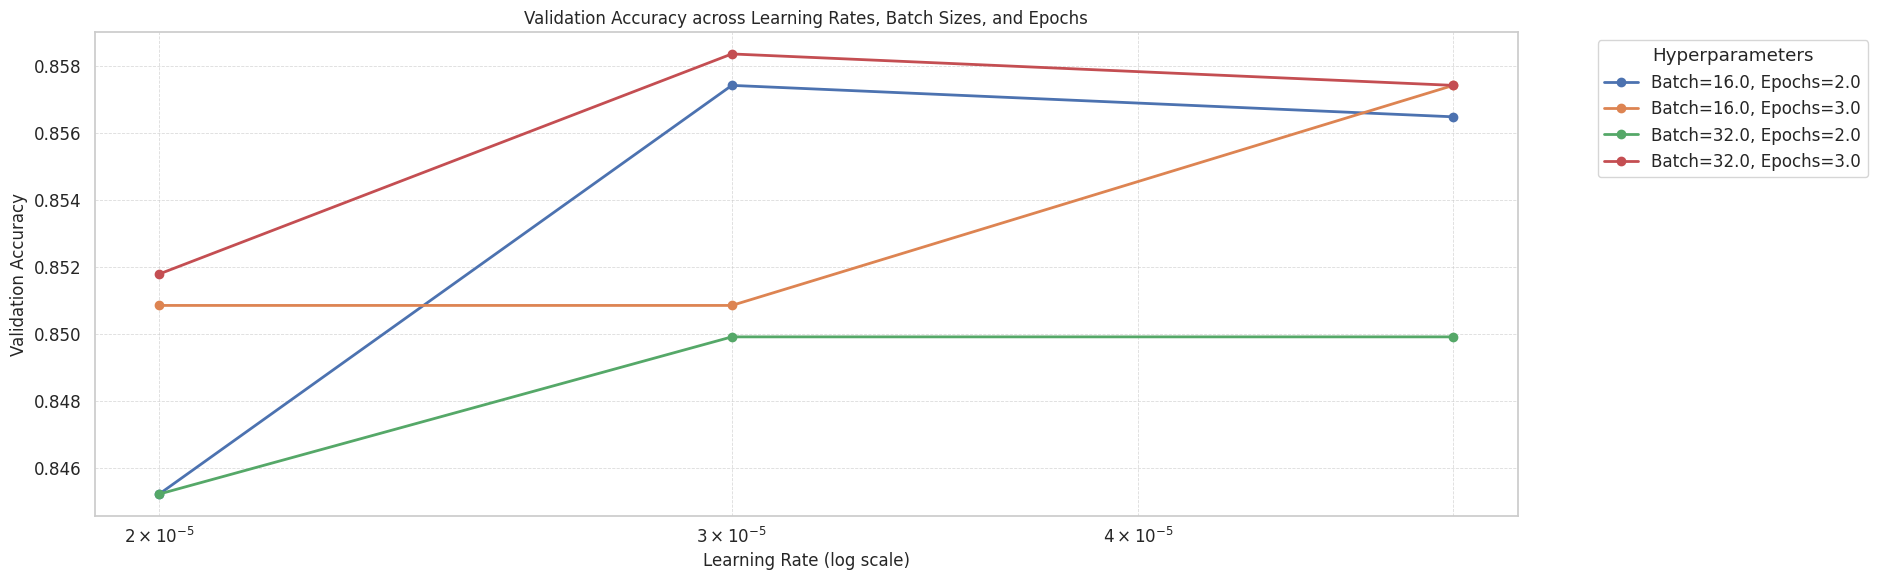

In [29]:
# Convert results list to DataFrame
df_results = pd.DataFrame(results_list)

# Sort for nicer plotting
df_results = df_results.sort_values(by=["batch_size", "lr", "epochs"]).reset_index(drop=True)

# Create a combined label for legend (batch size + epochs)
df_results["label"] = df_results.apply(lambda x: f"Batch={x.batch_size}, Epochs={x.epochs}", axis=1)

# Set visual style
sns.set(style="whitegrid", font_scale=1.1)
plt.figure(figsize=(19, 6))

# Plot accuracy curves
for label in df_results["label"].unique():
    subset = df_results[df_results["label"] == label]
    plt.plot(
        subset["lr"],
        subset["val_acc"],
        marker="o",
        linestyle="-",
        linewidth=2,
        markersize=6,
        label=label,
    )

# Format the plot
plt.xscale("log")
plt.xlabel("Learning Rate (log scale)", fontsize=12)
plt.ylabel("Validation Accuracy", fontsize=12)
plt.title("Validation Accuracy across Learning Rates, Batch Sizes, and Epochs", fontsize=12)
plt.legend(title="Hyperparameters", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True, which="both", linestyle="--", linewidth=0.6, alpha=0.7)
plt.tight_layout()
plt.show()

### 5.3 Evaluation on test set

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).



Test set evaluation metrics:
Accuracy : 0.8499
Precision: 0.8486
Recall   : 0.8518
F1-score : 0.8502


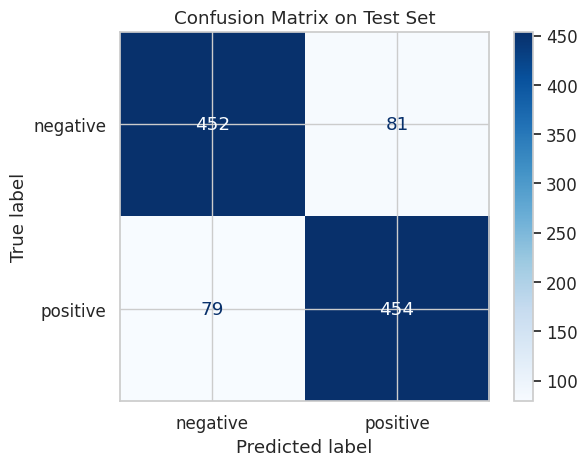

In [15]:
# Load saved fine-tuned model and tokenizer
model_path = "./bert_finetuned"
model_best = AutoModelForSequenceClassification.from_pretrained(model_path).to(device)
tokenizer_best = AutoTokenizer.from_pretrained(model_path)

# Tokenize test set
def tokenize_bert(examples):
    return tokenizer_best(
        examples["text"],
        truncation=True,
        padding="max_length",
        max_length=128
    )

tokenized_test_bert = dataset['test'].map(tokenize_bert, batched=True)

# Metrics function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="binary")
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

# Initialize Trainer
trainer_test = Trainer(
    model=model_best,
    tokenizer=tokenizer_best,
    data_collator=default_data_collator,
    compute_metrics=compute_metrics
)

# Evaluate on test set
test_metrics = trainer_test.evaluate(tokenized_test_bert)

print("\nTest set evaluation metrics:")
print(f"Accuracy : {test_metrics['eval_accuracy']:.4f}")
print(f"Precision: {test_metrics['eval_precision']:.4f}")
print(f"Recall   : {test_metrics['eval_recall']:.4f}")
print(f"F1-score : {test_metrics['eval_f1']:.4f}")

# ✅ Optional: Confusion matrix
preds_output = trainer_test.predict(tokenized_test_bert)
pred_labels = np.argmax(preds_output.predictions, axis=1)
true_labels = preds_output.label_ids

cm = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(cm, display_labels=["negative", "positive"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix on Test Set")
plt.show()

---

## 5. Fine-tuning a bidirectional model: distilbert-base-uncased

### 5.1. Model training

In [16]:
# Load tokenizer and model
model_name_distil = "distilbert-base-uncased"
tokenizer_distil = AutoTokenizer.from_pretrained(model_name_distil)

model_distil = AutoModelForSequenceClassification.from_pretrained(
    model_name_distil,
    num_labels=2  # positive/negative
).to(device)

# Tokenize dataset
def tokenize_distilbert(examples):
    return tokenizer_distil(
        examples["text"],
        truncation=True,
        padding="max_length",
        max_length=128
    )

tokenized_train_distil = dataset["train"].map(tokenize_distilbert, batched=True)
tokenized_val_distil   = dataset["validation"].map(tokenize_distilbert, batched=True)

# Metrics function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="binary")
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

# Training arguments
training_args_distil = TrainingArguments(
    output_dir="./distilbert_finetuned",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="steps",    
    learning_rate=2e-5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=False,
    fp16=True if torch.cuda.is_available() else False,
    report_to="none",  # disables W&B/TensorBoard
    seed=42
)

# Initialize Trainer
trainer_distil = Trainer(
    model=model_distil,
    args=training_args_distil,
    train_dataset=tokenized_train_distil,
    eval_dataset=tokenized_val_distil,
    tokenizer=tokenizer_distil,
    compute_metrics=compute_metrics,
    data_collator=default_data_collator
)

# Train the model
trainer_distil.train()

# Evaluate on validation set
val_metrics = trainer_distil.evaluate()
print("\nValidation set metrics:")
print(val_metrics)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/8530 [00:00<?, ? examples/s]

Map:   0%|          | 0/1066 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.351726,0.847092,0.823427,0.883677,0.852489
2,0.348300,0.353615,0.846154,0.868263,0.816135,0.841393
3,0.348300,0.390792,0.850844,0.848881,0.853659,0.851263



Validation set metrics:
{'eval_loss': 0.39079156517982483, 'eval_accuracy': 0.850844277673546, 'eval_precision': 0.8488805970149254, 'eval_recall': 0.8536585365853658, 'eval_f1': 0.8512628624883068, 'eval_runtime': 2.7189, 'eval_samples_per_second': 392.073, 'eval_steps_per_second': 12.505, 'epoch': 3.0}


### 5.2 Hyperparameter optimization

In [17]:
# Your code for hyperparameter optimization here
# Define hyperparameter search space
learning_rates = [5e-5, 3e-5, 2e-5]
batch_sizes = [16, 32]
num_epochs = [2, 3]

best_accuracy = 0
best_params = {}
results_list = []

for lr, batch_size, epochs in product(learning_rates, batch_sizes, num_epochs):
    print(f"\nTraining with lr={lr}, batch_size={batch_size}, epochs={epochs}")

    # Training arguments
    training_args = TrainingArguments(
        output_dir="./distilbert_finetuned",
        num_train_epochs=epochs,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        eval_strategy="epoch",
        save_strategy="epoch",
        logging_strategy="steps",    
        learning_rate=lr,
        weight_decay=0.01,
        load_best_model_at_end=True,
        metric_for_best_model="accuracy",
        push_to_hub=False,
        fp16=True if torch.cuda.is_available() else False,
        report_to="none",  # disable W&B logging
        seed=42
    )

    # Initialize fresh model for each run
    model = AutoModelForSequenceClassification.from_pretrained(
        "distilbert-base-uncased",
        num_labels=2
    ).to(device)

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train_distil,
        eval_dataset=tokenized_val_distil,
        tokenizer=tokenizer_distil,
        compute_metrics=compute_metrics,
        data_collator=default_data_collator
    )

    # Train & evaluate
    trainer.train()
    metrics = trainer.evaluate()
    val_acc = metrics["eval_accuracy"]
    print(f"Validation accuracy: {val_acc:.4f}")

    # Track best hyperparameters
    if val_acc > best_accuracy:
        best_accuracy = val_acc
        best_params = {"lr": lr, "batch_size": batch_size, "epochs": epochs}

    # Store results for plotting
    results_list.append({
        "lr": lr,
        "batch_size": batch_size,
        "epochs": epochs,
        "val_acc": val_acc
    })

print("\nBest hyperparameters found:")
print(best_params)
print(f"Validation accuracy with best hyperparameters: {best_accuracy:.4f}")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training with lr=5e-05, batch_size=16, epochs=2


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.342531,0.848968,0.830961,0.876173,0.852968
2,0.310000,0.367967,0.856473,0.865385,0.844278,0.854701


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Validation accuracy: 0.8565

Training with lr=5e-05, batch_size=16, epochs=3


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.358863,0.844278,0.803306,0.911820,0.854130
2,0.314900,0.366066,0.850844,0.856870,0.842402,0.849574
3,0.314900,0.631426,0.857411,0.854749,0.861163,0.857944


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Validation accuracy: 0.8574

Training with lr=5e-05, batch_size=32, epochs=2


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.343565,0.838649,0.826401,0.857411,0.841621
2,No log,0.355179,0.849906,0.849906,0.849906,0.849906


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Validation accuracy: 0.8499

Training with lr=5e-05, batch_size=32, epochs=3


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.347143,0.857411,0.844485,0.876173,0.860037
2,No log,0.356376,0.849906,0.848598,0.851782,0.850187
3,No log,0.431386,0.848968,0.833333,0.872420,0.852429


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Validation accuracy: 0.8574

Training with lr=3e-05, batch_size=16, epochs=2


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.341148,0.852720,0.834520,0.879925,0.856621
2,0.334800,0.347151,0.857411,0.867052,0.844278,0.855513


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Validation accuracy: 0.8574

Training with lr=3e-05, batch_size=16, epochs=3


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.347799,0.848030,0.821490,0.889306,0.854054
2,0.332800,0.353750,0.850844,0.887967,0.803002,0.843350
3,0.332800,0.432584,0.848030,0.844156,0.853659,0.848881


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Validation accuracy: 0.8508

Training with lr=3e-05, batch_size=32, epochs=2


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.355065,0.841463,0.846008,0.834897,0.840415
2,No log,0.354526,0.849906,0.848598,0.851782,0.850187


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Validation accuracy: 0.8499

Training with lr=3e-05, batch_size=32, epochs=3


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.349253,0.845216,0.844569,0.846154,0.845361
2,No log,0.339518,0.852720,0.856061,0.848030,0.852026
3,No log,0.377946,0.858349,0.838652,0.887430,0.862352


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Validation accuracy: 0.8583

Training with lr=2e-05, batch_size=16, epochs=2


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.349740,0.840525,0.833028,0.851782,0.842301
2,0.360600,0.352249,0.845216,0.852490,0.834897,0.843602


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Validation accuracy: 0.8452

Training with lr=2e-05, batch_size=16, epochs=3


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.355349,0.848968,0.826316,0.883677,0.854034
2,0.356500,0.351501,0.850844,0.884774,0.806754,0.843965
3,0.356500,0.383302,0.850844,0.850187,0.851782,0.850984


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Validation accuracy: 0.8508

Training with lr=2e-05, batch_size=32, epochs=2


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.363715,0.834897,0.833645,0.836773,0.835206
2,No log,0.360166,0.845216,0.842007,0.849906,0.845938


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Validation accuracy: 0.8452

Training with lr=2e-05, batch_size=32, epochs=3


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.357029,0.836773,0.840607,0.831144,0.835849
2,No log,0.344716,0.849906,0.859345,0.836773,0.847909
3,No log,0.361888,0.851782,0.844037,0.863039,0.853432


Validation accuracy: 0.8518

Best hyperparameters found:
{'lr': 3e-05, 'batch_size': 32, 'epochs': 3}
Validation accuracy with best hyperparameters: 0.8583


In [18]:
# Save the best DistilBERT model
trainer_distil.model.save_pretrained("./distilbert_finetuned")

# Save the tokenizer
tokenizer_distil.save_pretrained("./distilbert_finetuned")

print("DistilBERT model and tokenizer saved successfully!")

DistilBERT model and tokenizer saved successfully!


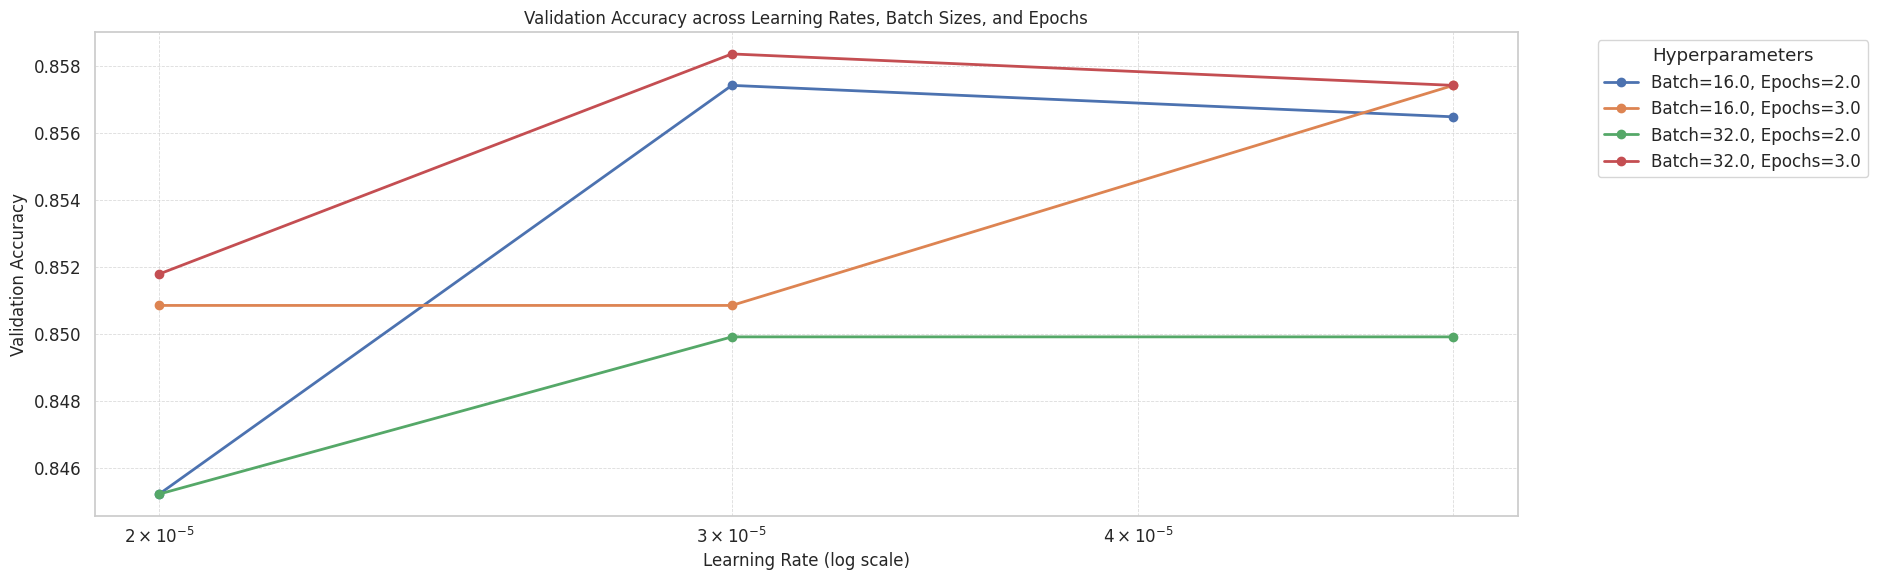

In [30]:
# Convert results list to DataFrame
df_results = pd.DataFrame(results_list)

# Sort for nicer plotting
df_results = df_results.sort_values(by=["batch_size", "lr", "epochs"]).reset_index(drop=True)

# Create a combined label for legend (batch size + epochs)
df_results["label"] = df_results.apply(lambda x: f"Batch={x.batch_size}, Epochs={x.epochs}", axis=1)

# Set visual style
sns.set(style="whitegrid", font_scale=1.1)
plt.figure(figsize=(19, 6))

# Plot accuracy curves
for label in df_results["label"].unique():
    subset = df_results[df_results["label"] == label]
    plt.plot(
        subset["lr"],
        subset["val_acc"],
        marker="o",
        linestyle="-",
        linewidth=2,
        markersize=6,
        label=label,
    )

# Format the plot
plt.xscale("log")
plt.xlabel("Learning Rate (log scale)", fontsize=12)
plt.ylabel("Validation Accuracy", fontsize=12)
plt.title("Validation Accuracy across Learning Rates, Batch Sizes, and Epochs", fontsize=12)
plt.legend(title="Hyperparameters", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True, which="both", linestyle="--", linewidth=0.6, alpha=0.7)
plt.tight_layout()
plt.show()

### 5.3 Evaluation on test set

Map:   0%|          | 0/1066 [00:00<?, ? examples/s]

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).



Test set evaluation metrics:
Accuracy : 0.8396
Precision: 0.8364
Recall   : 0.8443
F1-score : 0.8403


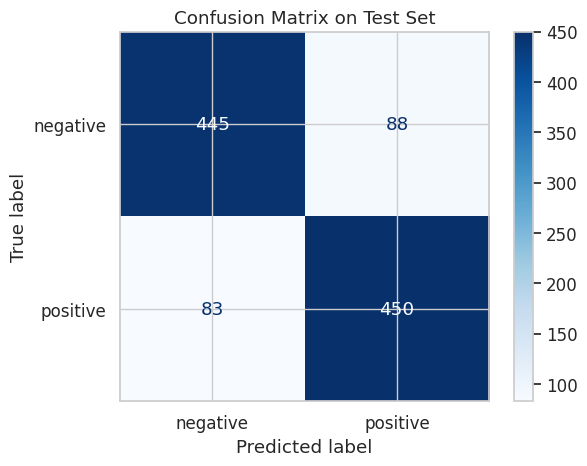

In [33]:
# Load saved fine-tuned model and tokenizer
model_path = "./distilbert_finetuned"
model_best = AutoModelForSequenceClassification.from_pretrained(model_path).to(device)
tokenizer_best = AutoTokenizer.from_pretrained(model_path)

# Tokenize test set
def tokenize_bert(examples):
    return tokenizer_best(
        examples["text"],
        truncation=True,
        padding="max_length",
        max_length=128
    )

tokenized_test_bert = dataset['test'].map(tokenize_bert, batched=True)

# ✅ Metrics function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="binary")
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

# ✅ Initialize Trainer
trainer_test = Trainer(
    model=model_best,
    tokenizer=tokenizer_best,
    data_collator=default_data_collator,
    compute_metrics=compute_metrics
)

# ✅ Evaluate on test set
test_metrics = trainer_test.evaluate(tokenized_test_bert)

print("\nTest set evaluation metrics:")
print(f"Accuracy : {test_metrics['eval_accuracy']:.4f}")
print(f"Precision: {test_metrics['eval_precision']:.4f}")
print(f"Recall   : {test_metrics['eval_recall']:.4f}")
print(f"F1-score : {test_metrics['eval_f1']:.4f}")

# Optional: Confusion matrix
preds_output = trainer_test.predict(tokenized_test_bert)
pred_labels = np.argmax(preds_output.predictions, axis=1)
true_labels = preds_output.label_ids

cm = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(cm, display_labels=["negative", "positive"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix on Test Set")
plt.show()

---

## 6. Bonus Task (optional)

Repeat sections 3 through 5 here for a second generative and a second bidirectional model. When summarizing your results below (Section 7), include also comparison of the two generative models and the two bidirectional models.

---

## 7. Results and summary

### 7.1 Corpus insights

(Briefly discuss what you learned about the corpus and its annotation)

### 7.2 Results

(Briefly summarize your results)

### 7.3 Relation to random baseline / expected performance / state of the art

(Compare your results with the random and state-of-the-art performance)

---

## 8 Error analysis (group projects only)

(Present the error analysis results here)